 We will implement **transfer learning** on an object detection task using **YOLOV5** , and **FasterRCNN-InceptionResNetV2** models. We will import these two object detection models from **torch hub** and **tensorflow hub** to detect objects in the following image.

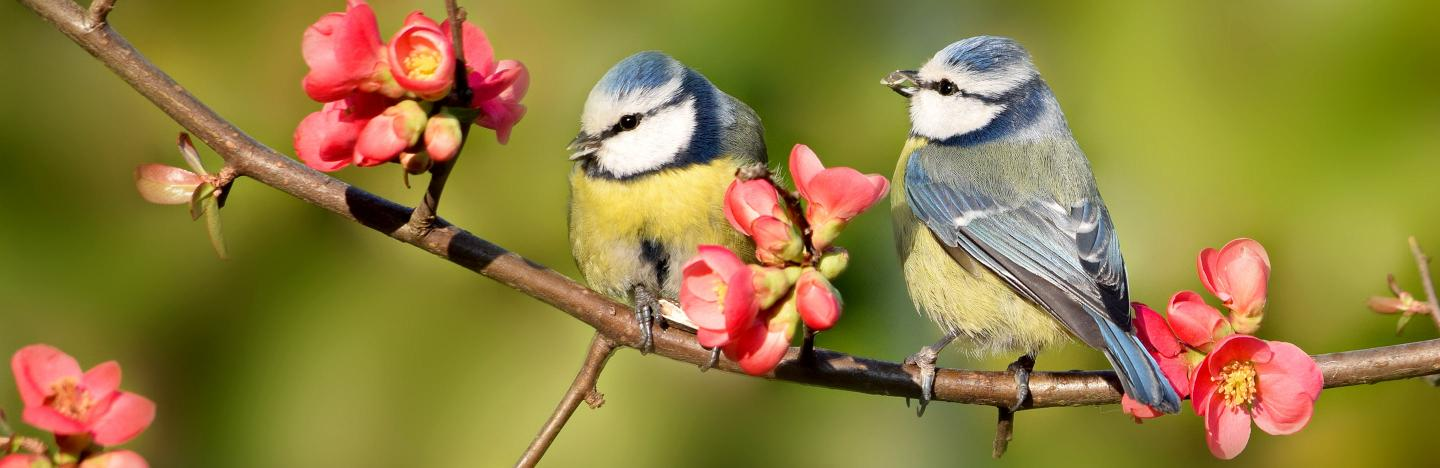

In [22]:
 !pip install --upgrade tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import torch.hub 

In [24]:
# import ulib.request library to download the image from the link
import urllib.request

urllib.request.urlretrieve('https://www.lovethegarden.com/sites/default/files/styles/header_image_xl/public/content/articles/UK_community-fun-facts-19-common-british-birds-you-can-find-your-garden_header.webp?itok=MweJ55ij', "birds.jpg")

# import Image module from Python Imaging Library (PIL) library to  open, manipulate, and save the image
from PIL import Image
img = Image.open('birds.jpg')
t = Image.open('/content/birds.jpg').convert('RGB')
t.save('birds.jpg', 'jpeg')

We will work on two famous models:

1. YOLO v5
2. FasterRCNN-InceptionResNet V2

## YOLO v5

YOLO divides the image into a grid, and then performs its analysis on each of its elements. YOLOv5 is an open-source project that consists of a family of object detection models and detection methods based on the pre-trained YOLO model.

In [25]:
#!pip install ultralytics

In [26]:
# PyTorch Hub Model source: https://github.com/ultralytics/yolov5
model = torch.hub.load("ultralytics/yolov5", "yolov5s")  # or yolov5n - yolov5x6, custom

# Images
img = '/content/birds.jpg'  # or file, Path, PIL, OpenCV, numpy, list

# Inference
results = model(img)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-23 Python-3.10.11 torch-2.0.1+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [27]:
results.print()

image 1/1: 468x1440 2 birds
Speed: 26.2ms pre-process, 237.4ms inference, 3.1ms NMS per image at shape (1, 3, 224, 640)


In [28]:
# Results object as a dataframe source: https://pytorch.org/hub/ultralytics_yolov5/
results = results.pandas().xyxy[0]
results

,xmin,ymin,xmax,ymax,confidence,class,name
0,881.265808,31.686201,1177.558472,439.160614,0.897585,14,bird
1,565.442383,48.123825,775.744202,371.006989,0.675069,14,bird


xmin, xmax, ymin, and ymax are the coordinates of the bounding boxes around the detected objects. In our case, the model detected two objects which belong to the class number 14 or bird class. (YOLO is trained to detect objects from 80 different classes.)

In [29]:
# Let's plot the image with the resulting bounding boxes using the cv2.recatngle function.

import cv2 
image = cv2.imread(img)

for i in range(len(results)):
  object_detected = results.iloc[i,:]
  x_min = int(object_detected['xmin'])
  y_min = int(object_detected['ymin'])
  x_max = int(object_detected['xmax'])
  y_max = int(object_detected['ymax'])

  #cv2.rectangle(image, start_point, end_point, color, thickness)
  cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 3)
  # we can also visualize the percentage of confidence using cv2.putText
  cv2.putText(image, str(object_detected['name'] + " (" + str(int(object_detected['confidence']*100))) + "%)", (x_min+10,y_min+20), fontFace=cv2.CAP_ANY, fontScale=0.5, color=(255, 0, 0),thickness=2)


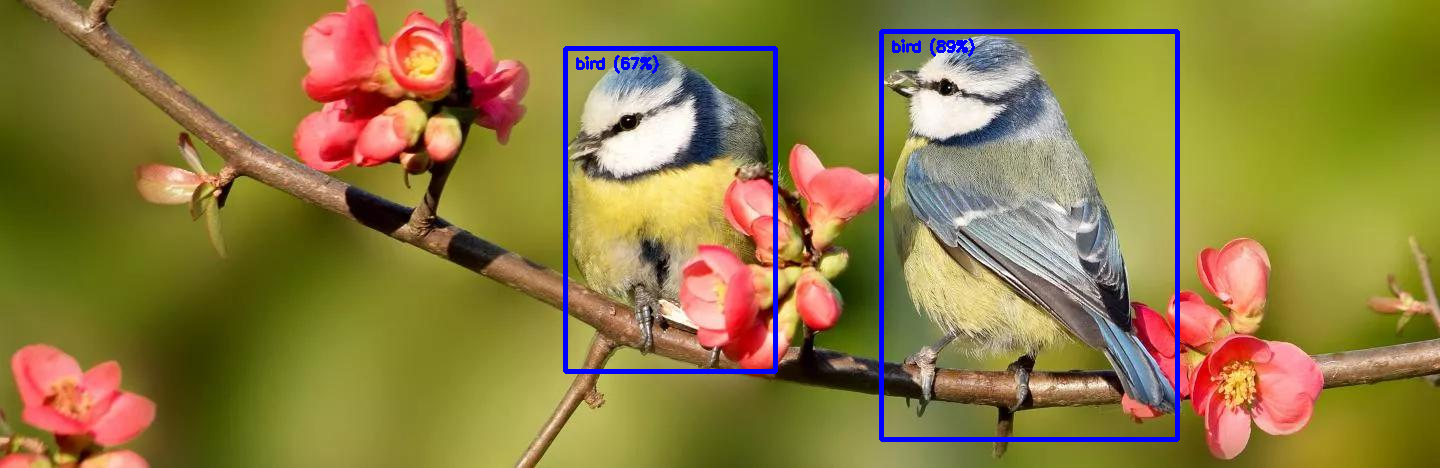

In [30]:
# Display the image with bounding boxes
from google.colab.patches import cv2_imshow
cv2_imshow(image)

## FasterRCNN-Inception ResNet V2

The Faster RCNN, is one of the most frequently used CNN networks for object detection and image recognition.we'll import from tensorflowhub.

In [31]:
module_handle ='https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1'
detector = hub.load(module_handle).signatures['default']

In [32]:
# We need to search for an image and preprocess it in a way to be suitable to be fed to the model
path = '/content/birds.jpg'

#read the file as tensor
img_1 = tf.io.read_file(path)


#channels indicates the desired number of color channels for the decoded image
# returns a tensor
img_1 = tf.image.decode_jpeg(img_1, channels=3)
img_1.shape

TensorShape([468, 1440, 3])

In [33]:
# Now let's feed the model our input image
converted_img  = tf.image.convert_image_dtype(img_1, tf.float32)[tf.newaxis, ... ]
result = detector(converted_img)
result = {key:value.numpy() for key,value in result.items()}
print(result)

{'detection_class_entities': array([b'Bird', b'Flower', b'Bird', b'Flower', b'Sparrow', b'Flower', b'Flower', b'Flower', b'Flower', b'Flower', b'Flower', b'Flower', b'Rose', b'Flower', b'Flower', b'Flower', b'Rose', b'Flower', b'Flower', b'Flower', b'Flower', b'Flower', b'Flower', b'Flower', b'Flower', b'Rose', b'Flower', b'Flower', b'Flower',
       b'Flower', b'Flower', b'Flower', b'Flower', b'Rose', b'Tree', b'Flower', b'Flower', b'Fruit', b'Flower', b'Rose', b'Flower', b'Flower', b'Flower', b'Flower', b'Flower', b'Flower', b'Plant', b'Canary', b'Flower', b'Rose', b'Flower', b'Bird', b'Flower', b'Flower', b'Canary', b'Flower', b'Fruit', b'Flower',
       b'Flower', b'Flower', b'Rose', b'Tree', b'Tree', b'Flower', b'Rose', b'Flower', b'Rose', b'Blue jay', b'Flower', b'Flower', b'Flower', b'Rose', b'Rose', b'Animal', b'Rose', b'Blue jay', b'Rose', b'Flower', b'Woodpecker', b'Lily', b'Fruit', b'Plant', b'Plant', b'Mammal', b'Rose', b'Rose', b'Rose', b'Tree',
       b'Plant', b'Woodpeck

In [34]:
image = cv2.imread(path)
im_height = image.shape[0]
im_width = image.shape[1]

for i in range(result['detection_boxes'].shape[0]):

  if result['detection_scores'][i]>0.7:
    y_min = int(result['detection_boxes'][i,0]*im_height)
    x_min = int(result['detection_boxes'][i,1]*im_width)
    y_max = int(result['detection_boxes'][i,2]*im_height)
    x_max = int(result['detection_boxes'][i,3]*im_width)

    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255,0,0), 4)
    cv2.putText(image, str(result['detection_class_entities'][i].decode("ascii")) + " (" + str(int(result['detection_scores'][i]*100)) + "%)", (x_min+10,y_min+20), fontFace=cv2.CAP_ANY, fontScale=0.5, color=(255, 0, 0),thickness=2)

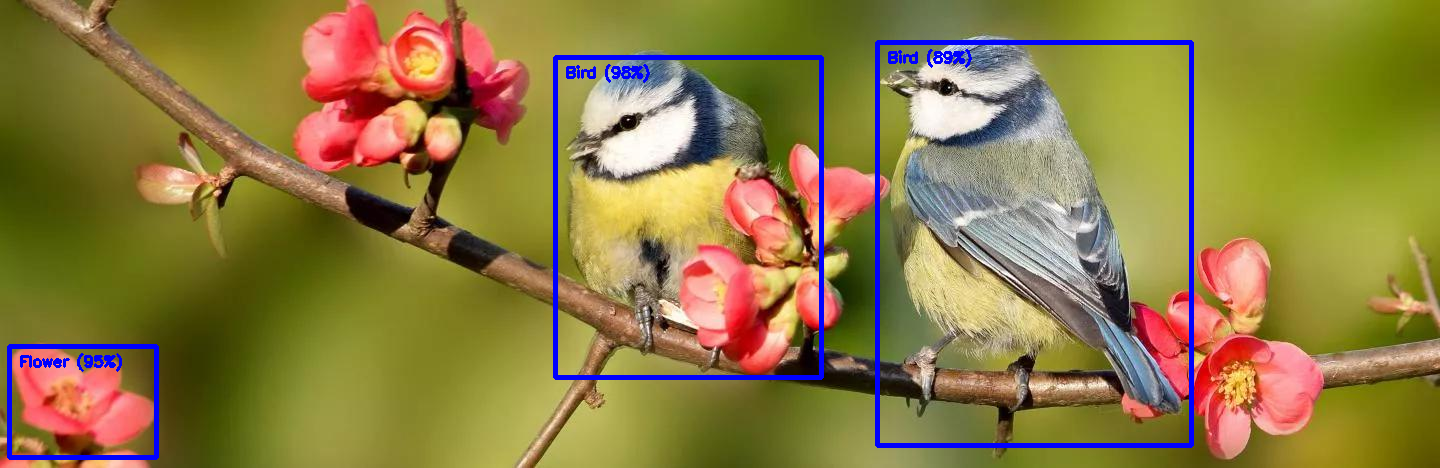

In [35]:
cv2_imshow(image)

Although this model takes more time to detect objects in an image, but it's more accurate than the previous one as it's shown from the confidence level.